**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 26 de setiembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido). En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Estudiante: Christopher Arredondo



## Leer esto primero.

1. Usted puede cambiar el dataset que se le proporciona por otro  que sea de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que su dataset propuesto no le agregue una complicación importante al Trabajo Práctico.

1. En caso de que el diseño experimental supere en mucho la capacidad de procesamiento computacional que puede conseguir, se le recomienda hablar con el profesor para valorar opciones como disminuir el tamaño del dataset.

## Indicaciones generales que deben seguir:

1. Se le proporciona el conjunto de datos y una hoja electrónica con detalles del dataset.

1. Realizarán clasificación y el atributo a predecir es: **melanocytic**.

1. Ustedes deben ir tomando las decisiones en el proceso y documentarlas en celdas de texto y además su código debe venir ampliamente comentado.

1. Se dividirá el dataset en tres conjuntos de datos: train (60%), validation (20%) y test (20%).

1. Ustedes proponen el diseño experimental (quiero ver qué han entendido de este concepto fundamental).

# Parte 1.  Experimentación con capas totalmente conectadas y un selector de hiperparámetros

1. Debe proponer una red neuronal artificial que solo incluya capas totalmente conectadas. Para la selección de hiperparámetros debe utilizar una herramienta especializada para esto (como keras tunner).






In [1]:
# Imports
import os
import pandas as pd
from PIL import Image
import numpy as np
from comet_ml import Experiment
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

2024-09-15 18:02:00.088545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 18:02:00.155578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 18:02:00.173417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 18:02:00.247895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 18:02:01.541677: W tensorflow/compiler/tf2

In [2]:
# Preprocess data
file_path = r"metadata.csv"
data = pd.read_csv(file_path)

# verify the data
data.head()

image_folder = 'ISIC-images/'

# Function to load and preprocess an image
def load_image(image_id, target_size=(128, 128)):
    image_path = os.path.join(image_folder, f'{image_id}.jpg')
    img = Image.open(image_path).resize(target_size)
    # Normalize the image
    img = np.array(img) / 255.0  
    return img

# Apply the function to all image IDs in the CSV
image_data = []
for image_id in data['isic_id']:
    try:
        img = load_image(image_id)
        image_data.append(img)
    except FileNotFoundError:
        print(f"Image {image_id} not found")

# Convert to a NumPy array
X_images = np.array(image_data)

# Labels are in the 'melanocytic' column
y_labels = data['melanocytic'].values

# Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_images, y_labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((7032, 128, 128, 3), (2344, 128, 128, 3), (2344, 128, 128, 3))

In [3]:
# Model with fully connected layers
def build_fc_model():
    model = Sequential()
    
    # Flatten the image input (128x128x3) into a 1D vector
    model.add(Flatten(input_shape=(128, 128, 3)))
    
    # ---- fully connected layers ----
    model.add(Dense(512, activation='relu')) 
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # --------------------------------

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
# hyperparameter tuning for Fully connected layers
def build_tuner_fc_model(hp):
    model = Sequential()

    # Flatten the image input (128x128x3) into a 1D vector
    model.add(Flatten(input_shape=(128, 128, 3)))
    
    # Tune the number of dense layers (1 to 4)
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        # Tune the number of units in each Dense layer (between 32 and 512)
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        model.add(Dense(units=hp_units, activation='relu'))
    
    # binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
## Run the model and the Tuner
experiment = Experiment(
    api_key="PlpkGnOY9fq5A1vs3IB2p4kZr",
    project_name="melanocytic_classification_fcc",
    workspace="chrisarrefall"
)

with experiment.train():
    model_fc = build_fc_model()
    history_fc = model_fc.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)
    test_loss_fc, test_acc_fc = model_fc.evaluate(X_test, y_test)
    experiment.log_metric('test_accuracy_fc', test_acc_fc)
    experiment.log_metric('test_loss_fc', test_loss_fc)

# Tune and train the hyperparameter model (build_tuner_fc_model)
tuner = kt.Hyperband(build_tuner_fc_model, 
                     objective='val_accuracy', 
                     max_epochs=20, factor=3, 
                     directory='tuner_dir', 
                     project_name='melanocytic_classification_fine_tuning')

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model using the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
history_tuned = final_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Evaluate
test_loss_tuned, test_acc_tuned = final_model.evaluate(X_test, y_test)
experiment.log_metric('test_accuracy_tuned_fc', test_acc_tuned)
experiment.log_metric('test_loss_tuned_fc', test_loss_tuned)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/chrisarrefall/melanocytic-classification-fcc/243585c100584247a01189d3ff10e954

/home/chris/.local/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1726448643.442638  278348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726448643.591990  278348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726448643.592209  278348 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel m

Epoch 1/20


I0000 00:00:1726448647.748446  278856 service.cc:146] XLA service 0x7f71f4046f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726448647.748483  278856 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-15 18:04:07.770478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-15 18:04:07.913005: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-15 18:04:09.609881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 8 bytes spill stores, 8 bytes spill loads

2024-09-15 18:04:09.735946: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 

  5/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4529 - loss: 8.9841

I0000 00:00:1726448651.112957  278856 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/220 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6813 - loss: 3.2758

2024-09-15 18:04:13.058019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 8 bytes spill stores, 8 bytes spill loads

2024-09-15 18:04:14.094245: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 32 bytes spill stores, 32 bytes spill loads

2024-09-15 18:04:14.212362: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 32 bytes spill stores, 32 bytes spill loads

2024-09-15 18:04:14.747519: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_439', 8 bytes spill stores, 8 bytes spill loads

2024-09-15 18:04:14.772775: I external/local_xla/xla/stream_executor

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6820 - loss: 3.2467

2024-09-15 18:04:18.085359: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 8 bytes spill stores, 8 bytes spill loads



220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6822 - loss: 3.2396 - val_accuracy: 0.7841 - val_loss: 0.4741
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7894 - loss: 0.4562 - val_accuracy: 0.7884 - val_loss: 0.4355
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7825 - loss: 0.4694 - val_accuracy: 0.7602 - val_loss: 0.4710
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7922 - loss: 0.4444 - val_accuracy: 0.7705 - val_loss: 0.6755
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7861 - loss: 0.4401 - val_accuracy: 0.6711 - val_loss: 0.5504
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.4393 - val_accuracy: 0.7705 - val_loss: 0.4335
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7718 - loss: 0.4407 - val_accuracy: 0.7705 - val_loss: 0.4224
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7824 - loss: 0.4183 - val_accuracy: 0.7974 - va

2024-09-15 18:04:45.043509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382547456 exceeds 10% of free system memory.
2024-09-15 18:04:46.650139: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382547456 exceeds 10% of free system memory.


Epoch 1/20


2024-09-15 18:04:48.888374: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 52 bytes spill stores, 52 bytes spill loads

2024-09-15 18:04:48.981312: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 32 bytes spill stores, 32 bytes spill loads



209/220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7525 - loss: 0.5430

2024-09-15 18:04:52.146520: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_170', 16 bytes spill stores, 16 bytes spill loads

2024-09-15 18:04:52.576519: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_437', 32 bytes spill stores, 32 bytes spill loads



220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7536 - loss: 0.5401 - val_accuracy: 0.7927 - val_loss: 0.4317
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8000 - loss: 0.4224 - val_accuracy: 0.7688 - val_loss: 0.4594
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8059 - loss: 0.4226 - val_accuracy: 0.7619 - val_loss: 0.4712
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8049 - loss: 0.4251 - val_accuracy: 0.7965 - val_loss: 0.4231
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8069 - loss: 0.4104 - val_accuracy: 0.6642 - val_loss: 0.6029
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7808 - loss: 0.4703 - val_accuracy: 0.7884 - val_loss: 0.4299
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8158 - loss: 0.3969 - val_accuracy: 0.7974 - val_loss: 0.4105
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8193 - loss: 0.3923 - val_accuracy: 0.7794 - va

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : key_omega_3284
COMET INFO:     url                   : https://www.comet.com/chrisarrefall/melanocytic-classification-fcc/243585c100584247a01189d3ff10e954
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [20]                       : (0.772895336151123, 0.8363196849822998)
COMET INFO:     batch_accuracy [440]                : (0.5, 0.90625)
COMET INFO:     batch_loss [440]                    : (0.26749032735824585, 0.8291297554969788)
COMET INFO:     epoch_duration [20]                 : (1.0540516680048313, 9.806632674997672)
COMET INFO:     loss [20]                           : (0.3664243221282959, 0.489358127117157)
COMET INFO:   

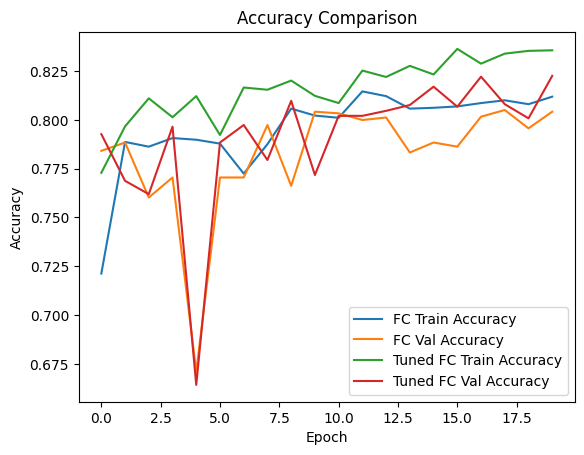

In [6]:
# Plot the results
plt.plot(history_fc.history['accuracy'], label='FC Train Accuracy')
plt.plot(history_fc.history['val_accuracy'], label='FC Val Accuracy')
plt.plot(history_tuned.history['accuracy'], label='Tuned FC Train Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Tuned FC Val Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Parte 2.  Experimentación con libertad de escogencia del tipo de capas

1. En esta segunda implementación puede incluir capas tipo CNN y cualquier otra que considere aporta a la solución.
1. Deben utilizar **una de estas herramientas** para dar seguimiento a los resultados en el caso de la red neuronal artificial -En caso de desear utilizar otra herramienta muy similar, solo solicite de previo autorización al profesor-:
    1. https://www.wandb.com/
    1. https://www.comet.ml/site/

In [7]:
def build_cnn_model():
    model = Sequential()
    # ---- CNN Layers ----
    # max pooling
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # batch normalization
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third cnn layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # --------------------

    # Flatten the feature maps into 1D
    model.add(Flatten())
    
    # Fully connected layer with dropout
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
# Function to build the model for hyperparameter tuning
def build_tuner_cnn_model(hp):
    model = Sequential()

    # Tune the number of filters and kernel size for the first convolutional layer
    hp_filters = hp.Int('filters_1', min_value=32, max_value=128, step=16)
    hp_kernel_size = hp.Choice('kernel_size_1', values=[3, 5])
    
    # ---- CNN Layers ----
    model.add(Conv2D(filters=hp_filters, kernel_size=(hp_kernel_size, hp_kernel_size), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tune the second convolutional layer
    hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=16)
    hp_kernel_size_2 = hp.Choice('kernel_size_2', values=[3, 5])
    model.add(Conv2D(filters=hp_filters_2, kernel_size=(hp_kernel_size_2, hp_kernel_size_2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tune the third convolutional layer
    hp_filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=32)
    hp_kernel_size_3 = hp.Choice('kernel_size_3', values=[3, 5])
    model.add(Conv2D(filters=hp_filters_3, kernel_size=(hp_kernel_size_3, hp_kernel_size_3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # --------------------

    # Flatten the feature maps into 1D
    model.add(Flatten())

    # Tune the number of units in the dense layer
    hp_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [9]:
## Run the model and the Tuner
experiment = Experiment(
    api_key="PlpkGnOY9fq5A1vs3IB2p4kZr",
    project_name="melanocytic_classification_cnn",
    workspace="chrisarrefall"
)

with experiment.train():
    model_cnn = build_cnn_model()
    history_cnn = model_cnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)
    test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test)
    experiment.log_metric('test_accuracy_cnn', test_acc_cnn)
    experiment.log_metric('test_loss_cnn', test_loss_cnn)

# Tune and train the hyperparameter CNN model (build_tuner_cnn_model)
tuner = kt.Hyperband(build_tuner_cnn_model, objective='val_accuracy', max_epochs=20, factor=3, directory='tuner_dir', project_name='cnn_melanocytic_fine_tuning')

# hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the optimal hyperparameters
best_hps_cnn = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model using the best hyperparameters
final_model_cnn = tuner.hypermodel.build(best_hps_cnn)

# Train the final model
history_tuned_cnn = final_model_cnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Evaluate
test_loss_tuned_cnn, test_acc_tuned_cnn = final_model_cnn.evaluate(X_test, y_test)
experiment.log_metric('test_accuracy_tuned_cnn', test_acc_tuned_cnn)
experiment.log_metric('test_loss_tuned_cnn', test_loss_tuned_cnn)

experiment.end()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/chrisarrefall/melanocytic-classification-cnn/a4d2aba585924e1aa70e5f8c5072c533

/home/chris/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-15 18:05:24.074697: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382547456 exceeds 10% of free system memory.


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7881 - loss: 0.9390 - val_accuracy: 0.2811 - val_loss: 0.7173
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8627 - loss: 0.3464 - val_accuracy: 0.6856 - val_loss: 0.5597
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8709 - loss: 0.3189 - val_accuracy: 0.8503 - val_loss: 0.3649
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8705 - loss: 0.3260 - val_accuracy: 0.7735 - val_loss: 0.5412
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8760 - loss: 0.3073 - val_accuracy: 0.7705 - val_loss: 0.6685
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8758 - loss: 0.2959 - val_accuracy: 0.8332 - val_loss: 0.3608
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8889 - loss: 0.2814 - val_accuracy: 0.7974 - val_loss: 0.4241
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8929 - loss: 0.2632 - val_accuracy

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : cloudy_east_5176
COMET INFO:     url                   : https://www.comet.com/chrisarrefall/melanocytic-classification-cnn/a4d2aba585924e1aa70e5f8c5072c533
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [20]                       : (0.8309158086776733, 0.9630261659622192)
COMET INFO:     batch_accuracy [440]                : (0.53125, 1.0)
COMET INFO:     batch_loss [440]                    : (0.07133850455284119, 0.6829627156257629)
COMET INFO:     epoch_duration [20]                 : (2.542932378986734, 14.353353593003703)
COMET INFO:     loss [20]                           : (0.09625127911567688, 0.38021767139434814)
COMET IN

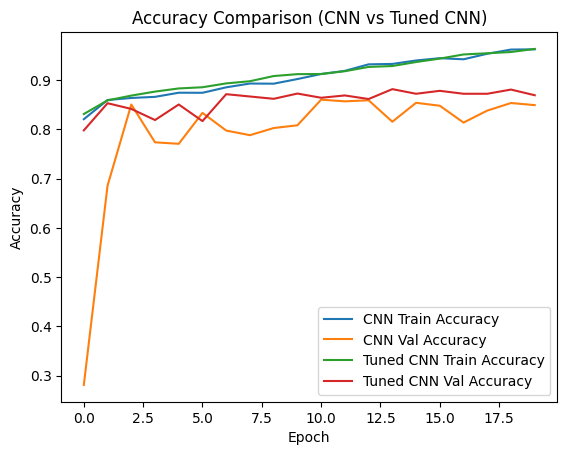

In [10]:
plt.plot(history_cnn.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(history_tuned_cnn.history['accuracy'], label='Tuned CNN Train Accuracy')
plt.plot(history_tuned_cnn.history['val_accuracy'], label='Tuned CNN Val Accuracy')
plt.title('Accuracy Comparison (CNN vs Tuned CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Criterios de evaluación:
1. Deben presentar una implementación completa para la Parte 1 y para la Parte 2, en una de estas opciones: pytorch, tensorflow o keras (Claro que pueden usar numpy, pandas y otras bibliotecas más, para todo el tema de carga del dataset, analizarlo y pre-procesarlo). (**30 puntos cada una (total 60 ))**
1. Uso de herramienta de seguimiento de resultados. (**10 puntos**)
1. Uso de herramienta de selección de hiperparámetros. (**10 puntos**)
1. Documentación de decisiones en celdas de texto y comentarios al código. (**10 puntos**)
1. Conclusiones finales: En una celda de texto al final del cuaderno, incluya sus conclusiones más importantes de los experimentos y algunos de los gráficos que genera la herramienta seleccionada, junto con su interpretación de los mismos. (**10 puntos**)